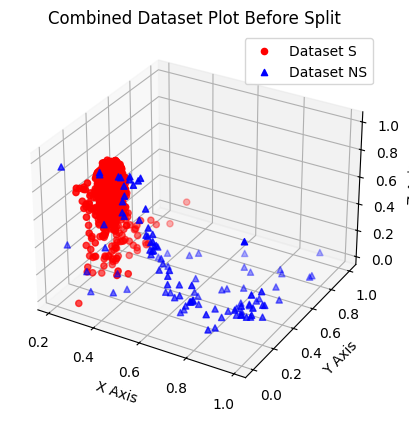

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_3d_scatter_two_datasets(x1, y1, z1, x2, y2, z2, title):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x1, y1, z1, c='r', marker='o', label='Dataset S')
    
    ax.scatter(x2, y2, z2, c='b', marker='^', label='Dataset NS')
    
    ax.set_title(title)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.legend()
    
    plt.show()

S = pd.read_excel('S.xlsx', header=None)
NS = pd.read_excel('NS.xlsx', header=None)

x1, y1, z1 = S[0], S[1], S[2]
x2, y2, z2 = NS[0], NS[1], NS[2]

plot_3d_scatter_two_datasets(x1, y1, z1, x2, y2, z2, "Combined Dataset Plot Before Split")

Dataset S: 3987 rows, Train: 1993 rows, Test: 1994 rows
Dataset NS: 109 rows, Train: 54 rows, Test: 55 rows


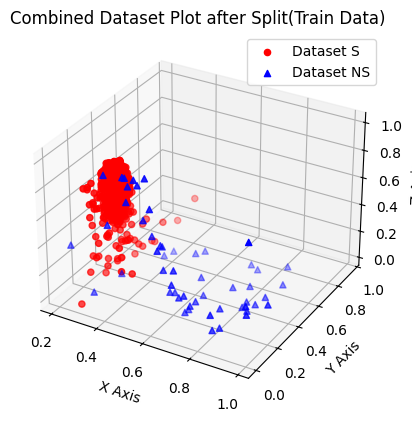

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def split_dataset(data):
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    midpoint = len(data) // 2
    train = data.iloc[:midpoint]
    test = data.iloc[midpoint:]
    return train, test

train_S, test_S = split_dataset(S)
train_NS, test_NS = split_dataset(NS)

print(f"Dataset S: {len(S)} rows, Train: {len(train_S)} rows, Test: {len(test_S)} rows")
print(f"Dataset NS: {len(NS)} rows, Train: {len(train_NS)} rows, Test: {len(test_NS)} rows")

x1_train, y1_train, z1_train = train_S[0], train_S[1], train_S[2]
x1_test, y1_test, z1_test = test_S[0], test_S[1], test_S[2]

x2_train, y2_train, z2_train = train_NS[0], train_NS[1], train_NS[2]
x2_test, y2_test, z2_test = test_NS[0], test_NS[1], test_NS[2]

plot_3d_scatter_two_datasets(x1_train, y1_train, z1_train, x2_train, y2_train, z2_train, "Combined Dataset Plot after Split(Train Data)")

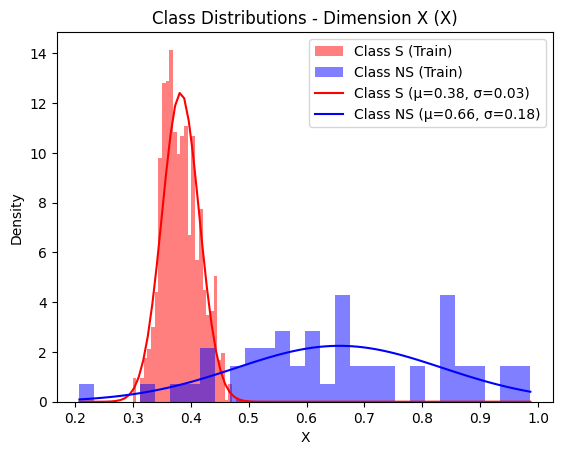

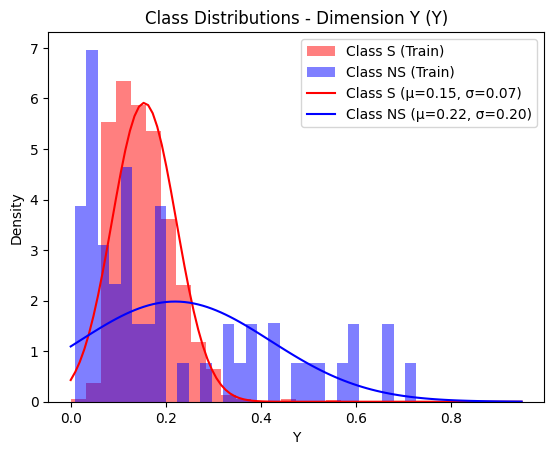

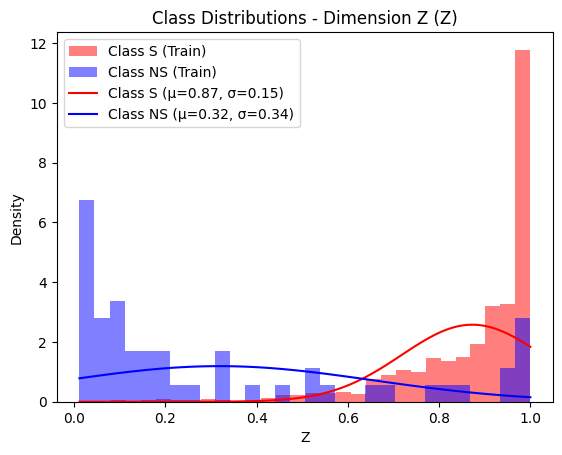

In [30]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_class_distributions(x_train_S, x_train_NS, title, dimension_label):
    mean_S, std_S = np.mean(x_train_S), np.std(x_train_S)
    mean_NS, std_NS = np.mean(x_train_NS), np.std(x_train_NS)
    
    x = np.linspace(min(min(x_train_S), min(x_train_NS)), 
                    max(max(x_train_S), max(x_train_NS)), 100)
    
    pdf_S = stats.norm.pdf(x, mean_S, std_S)
    pdf_NS = stats.norm.pdf(x, mean_NS, std_NS)
    
    plt.hist(x_train_S, bins=30, density=True, alpha=0.5, color='r', label='Class S (Train)')
    plt.hist(x_train_NS, bins=30, density=True, alpha=0.5, color='b', label='Class NS (Train)')
    
    plt.plot(x, pdf_S, 'r-', label=f'Class S (μ={mean_S:.2f}, σ={std_S:.2f})')
    plt.plot(x, pdf_NS, 'b-', label=f'Class NS (μ={mean_NS:.2f}, σ={std_NS:.2f})')
    
    plt.title(f"{title} ({dimension_label})")
    plt.xlabel(dimension_label)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_class_distributions(x1_train, x2_train, "Class Distributions - Dimension X", "X")
plot_class_distributions(y1_train, y2_train, "Class Distributions - Dimension Y", "Y")
plot_class_distributions(z1_train, z2_train, "Class Distributions - Dimension Z", "Z")

In [31]:
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd

def fit_multivariate_normal(data):
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    return mean, cov

def predict_class(test_data, mean_S, cov_S, mean_NS, cov_NS):
    pdf_S = multivariate_normal(mean=mean_S, cov=cov_S).pdf(test_data)
    pdf_NS = multivariate_normal(mean=mean_NS, cov=cov_NS).pdf(test_data)
    return np.where(pdf_S > pdf_NS, 0, 1)  # 0 = Class S, 1 = Class NS

def count_misclassifications_by_class(test_data, true_labels, mean_S, cov_S, mean_NS, cov_NS):
    predicted_labels = predict_class(test_data, mean_S, cov_S, mean_NS, cov_NS)
    
    misclassification_S = np.sum((true_labels == 0) & (predicted_labels != 0))
    misclassification_NS = np.sum((true_labels == 1) & (predicted_labels != 1))
    
    return misclassification_S, misclassification_NS

train_S = train_S.to_numpy()
test_S = test_S.to_numpy()
train_NS = train_NS.to_numpy()
test_NS = test_NS.to_numpy()


mean_S, cov_S = fit_multivariate_normal(train_S)
mean_NS, cov_NS = fit_multivariate_normal(train_NS)


print("Best Normal Distribution Parameters:")
print("Class S:")
print(f"Mean: {mean_S}")
print(f"Covariance Matrix:\n{cov_S}\n")

print("Class NS:")
print(f"Mean: {mean_NS}")
print(f"Covariance Matrix:\n{cov_NS}\n")


true_labels_S = np.zeros(len(test_S))  
true_labels_NS = np.ones(len(test_NS))  


test_data = np.vstack([test_S, test_NS])
true_labels = np.hstack([true_labels_S, true_labels_NS])


misclassification_S, misclassification_NS = count_misclassifications_by_class(
    test_data, true_labels, mean_S, cov_S, mean_NS, cov_NS
)

print(f"Misclassifications for Class S: {misclassification_S}")
print(f"Misclassifications for Class NS: {misclassification_NS}")
print(f"Total Misclassifications: {misclassification_S + misclassification_NS}")
print(f"Overall Misclassification Rate: {(misclassification_S + misclassification_NS) / len(test_data):.2%}")

Best Normal Distribution Parameters:
Class S:
Mean: [0.38281146 0.15455548 0.87268774]
Covariance Matrix:
[[ 0.00103167 -0.00145981  0.0034714 ]
 [-0.00145981  0.00455358 -0.00781039]
 [ 0.0034714  -0.00781039  0.02398114]]

Class NS:
Mean: [0.65654219 0.21953292 0.31830065]
Covariance Matrix:
[[ 0.03214371  0.00976153 -0.02647581]
 [ 0.00976153  0.04129421 -0.04307901]
 [-0.02647581 -0.04307901  0.11447252]]

Misclassifications for Class S: 55
Misclassifications for Class NS: 1
Total Misclassifications: 56
Overall Misclassification Rate: 2.73%


KNN - k-Nearest Neighbors

In [32]:
from scipy.spatial import distance
import numpy as np

def knn_predict(train_data, train_labels, test_data, k):
    predicted_labels = []
    for test_point in test_data:
        distances = distance.cdist([test_point], train_data, metric='euclidean').flatten()
        
        nearest_indices = np.argsort(distances)[:k]
        
        nearest_labels = train_labels[nearest_indices]
        
        predicted_labels.append(np.bincount(nearest_labels).argmax())
    
    return np.array(predicted_labels)

def compute_accuracy(true_labels, predicted_labels):
   
    correct = np.sum(true_labels == predicted_labels)
    accuracy = correct / len(true_labels) * 100
    return accuracy

train_data = np.vstack([train_S, train_NS])
train_labels = np.hstack([np.zeros(len(train_S), dtype=int), np.ones(len(train_NS), dtype=int)])

test_data = np.vstack([test_S, test_NS])
true_labels = np.hstack([np.zeros(len(test_S), dtype=int), np.ones(len(test_NS), dtype=int)]) 

k_values = [1, 3, 5, 7]
for k in k_values:
    predicted_labels = knn_predict(train_data, train_labels, test_data, k)
    accuracy = compute_accuracy(true_labels, predicted_labels)
    print(f"k = {k}: Accuracy = {accuracy:.2f}%")

k = 1: Accuracy = 99.66%
k = 3: Accuracy = 99.71%
k = 5: Accuracy = 99.66%
k = 7: Accuracy = 99.66%


SVM - Support Vector Machine

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_parameters = [
    {'C': 1, 'kernel': 'linear'},
    {'C': 10, 'kernel': 'linear'},
    {'C': 100, 'kernel': 'linear'},
    {'C': 1, 'kernel': 'rbf', 'gamma': 0.1},
    {'C': 1, 'kernel': 'rbf', 'gamma': 0.01},
    {'C': 10, 'kernel': 'rbf', 'gamma': 0.1},
    {'C': 10, 'kernel': 'rbf', 'gamma': 0.01},
    {'C': 100, 'kernel': 'rbf', 'gamma': 0.01},
    {'C': 100, 'kernel': 'rbf', 'gamma': 0.001},
]

for params in svm_parameters:
    svm_model = SVC(C=params['C'], kernel=params['kernel'], gamma=params.get('gamma', 'auto'))
    svm_model.fit(train_data, train_labels)
    predicted_labels = svm_model.predict(test_data)
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Parameters: {params} -> Accuracy: {accuracy*100:.2f}%")

Parameters: {'C': 1, 'kernel': 'linear'} -> Accuracy: 99.27%
Parameters: {'C': 10, 'kernel': 'linear'} -> Accuracy: 99.46%
Parameters: {'C': 100, 'kernel': 'linear'} -> Accuracy: 99.66%
Parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 0.1} -> Accuracy: 98.88%
Parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 0.01} -> Accuracy: 97.32%
Parameters: {'C': 10, 'kernel': 'rbf', 'gamma': 0.1} -> Accuracy: 99.46%
Parameters: {'C': 10, 'kernel': 'rbf', 'gamma': 0.01} -> Accuracy: 98.88%
Parameters: {'C': 100, 'kernel': 'rbf', 'gamma': 0.01} -> Accuracy: 99.46%
Parameters: {'C': 100, 'kernel': 'rbf', 'gamma': 0.001} -> Accuracy: 98.88%
